# samenvatting

Het doel van dit onderzoek was om erachter te komen hoe de alphahelices van Receptor tyrosine kinases (RTKs) die in de membranen zitten waar deze RTK eiwitten in zitten, met elkaar samenwerken en hoe de plaatsing van deze dimeren ten opzichte van elkaar en het membraan, te maken heeft met de sterkte van de interactie tussen de alphahelices.
De data waarmee gewerkt werd, was alsvolgt opgebouwd: er waren 18 eiwitten en voor elk van die eiwitten waren er tussen de 400 en 500 runs gedaan met Docking Assay For Transmembrane components (DAFT) en voor elk van deze runs waren er coordinaten bekend van de alphahelices in 3d (dus per aminozuur een X een Y en een Z coordinaat) en dat gemeten op elke 500 picoseconden en de vrije energie tussen beide helices, elk van de helices met het membraan, en de energie in het membraan zelf ook elke 500 picoseconden.
Eerst zijn de interessante datapunten per eiwit opgezocht (daar waar de vrije energie tussen de helices in de hoogste 5% viel) en deze zijn gemarkeerd. Vervolgens is met behulp van de python module numpy een orientatie gemaakt, waarbij vanaf de bovenkant van de helix gezien, residues 4 tot 9 van helix 1 als de center werd gebruikt en residues 4 tot 9 van helix 2 daar omheen zijn gepositioneerd, voor alle tijdpunten. Vervolgens is er per plaats rondom helix 1 gekeken hoeveel data daar lag. Toen eenmaal bekend was hoeveel van de data waar lag (zowel voor alle data als de interessante data), zijn de eiwitten verdeeld over 3 groepen naar aanleiding van de interactie sterkte en toen is er een 1way-ANOVA gedaan om te kijken of er verschil in plaatsing van de groepen was, maar dit bleek niet zo te zijn.

\clearpage

# Introductie

Receptor tyrosine kinases (RTKs) zijn receptoren die als dimeren functioneren en van belang zijn bij de ontwikkeling, metabole regulatie en het imuunsysteem. De manier van binden, de sterkte van de binding en de relatieve oriëntatie van de transmembraan (TM) domeinen zijn van groot belang voor de wetenschap, omdat het van groot belang is om de functie van deze eiwitten te begrijpen. Ook opent het wegen naar het moduleren van signaleren van en naar deze eiwitten. 
Het doel van dit onderzoek is om erachter te komen hoe de alphahelices van RTK eiwitten die in de membranen zitten waar deze RTK eiwitten in zitten, met elkaar samenwerken en hoe de plaatsing van deze dimeren ten opzichte van elkaar en het membraan, te maken heeft met de sterkte van de interactie tussen de alphahelices. 
Eerst zijn de interessante datapunten per eiwit opgezocht (daar waar de vrije energie tussen de helices in de hoogste 5% viel) en deze zijn gemarkeerd. Vervolgens is helix 1 als het centrum gebruikt en helix 2 daar omheen gepositioneerd. Vervolgens is er per plaats rondom helix 1 gekeken hoeveel data daar lag. Toen eenmaal bekend was hoeveel van de data waar lag (zowel voor alle data als de interessante data), zijn de eiwitten verdeeld over 3 groepen naar aanleiding van de interactie sterkte en toen is er een 1way-ANOVA gedaan om te kijken of er verschil in plaatsing van de groepen was, maar dit bleek niet zo te zijn. Alle gebruikte code is in dit rapport te vinden en van de plaatsing van de data rond helix 1 per groep is een barplot beschikbaar.

\clearpage

# Materiaal en Methode

## Inlezen data

Voor het inlezen en overzichtelijk houden van de data, is gebruik gemaakt van de module Pandas. Van de website van de module [1]: "pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language."

Aan het begin van het programma wordt het bestand met alle sequenties en interactie sterktes ingelezen en in een dataframe gezet, waarvan de bovenste 5 entries hieronder zichtbaar zijn, dat altijd beschikbaar is. Vervolgens wordt bij de analyse per eiwit de sequentie opgehaald en per Docking Assay For Transmembrane components (DAFT) run (tussen de 400 en 500 per eiwit) de coordinaten en energieën opgehaald en in een Pandas dataframe geplaatst.

### Sequentie dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import glob
import re
import os
from scipy.stats import kde, f_oneway
from bisect import bisect_left
from mpl_toolkits.mplot3d import Axes3D

sequences_dict = {}
with open("sequences.txt") as open_file:
    for line in open_file:
        split_line = line.split()
        # headerline
        if "Clone" in line:
            # protein, familie, sequence, interaction strength
            header = [split_line[2], split_line[3], " ".join(split_line[4:7]), 
                      " ".join(split_line[7:])]
        # if there is still anything in the line after stripping whitespaces away, 
        # treat it as data
        elif line.strip():
            items = []
            for item in split_line[1:4]:  # protein, family and sequence
                items.append(item)
            
            # interaction propensity
            items.append(" ".join(split_line[4:]))
            
            # protein: items
            sequences_dict[int(split_line[0])] = items
            
sequences_df = pd.DataFrame.from_dict(sequences_dict, "index")
sequences_df.columns = header
sequences_df = sequences_df.sort_index()
sequences_df.head()

Protein         Family               TM domain sequence  \
-1  GpA-WT  StrongControl             RASLIIFGVMAGVIGTILIN   
 1    DDR2            DDR      RASILIGCLVAIIFILLAIIVIILGIL   
 2    DDR1            DDR      RASILIGCLVAIILLLLLIIALMLGIL   
 3     LTK            ALK  RASLVLMVAVVATSTLSLLMVCGVLILVGIL   
 4    TIE1            TIE   RASLILAVVGSVSATCLTILAALLTLVGIL   

   Interaction propensity  
-1            1.00 ± 0.08  
 1            2.28 ± 0.45  
 2            1.69 ± 0.40  
 3            1.63 ± 0.14  
 4            1.31 ± 0.15

### Sequentie en interactie sterkte

Voor het overzichtelijk maken van de coordinaten dataframe, wordt een lijst gemaakt waarbij voor elke helix, de letters in de sequentie 3 keer voorkomen (omdat er per letter een X, een Y en een Z in coordinaten zit) en het nummer van de helix (1 of 2) met een punt erachter, dus voor helix 1 bijvoorbeeld A.1, A.1, A.1, B.1, B.1, B.1 en voor helix 2, hetzelfde residue A.2, A.2, A.2, B.2, B.2, B.2.

In [2]:
def get_sequence(protein):
    for i, p in enumerate(sequences_df.iloc[:, 0]):  # for every row the protein
        if p == protein:
            return sequences_df.iloc[i, 2]  # the sequence of the protein at index i.

def get_interaction_strength(protein):
    for i, p in enumerate(sequences_df.iloc[:, 0]):  # for every row the protein
        if p == protein:
            return sequences_df.iloc[i, 3]  # the sequence of the protein at index i.

def get_seq_list(sequence):
    sequence_list = list()
    for i in range(2):  # 2 helices
        for aa in sequence:
            for y in range(3):  # 3 times the specific aminoacid
                sequence_list.append(".".join([aa, str(i + 1)])) 

    # A.1, A.1, A.1, B.1, B.1, B.1 ... A.2, A.2, A.2, B.2, B.2, B.2 ...
    return sequence_list

### Energie

Het energie dataframe bevat voor elke run:
tijd, AA, AB, AM, AS, BB, BM, BS, MM, MS, SS, waarbij A voor helix 1 staat, B voor helix 2, M voor het membraan en S voor de oplossing waar alles in zit. dus AB is de energie tussen helix 1 en helix 2 en AA is de energie binnen helix 1. De tijd is in picoseconden en wordt elke 500 picoseconden gemeten.

In [3]:
def get_energy(file):
    p = "(.*)coords.dat"  # (path/to/file/)coords.dat
    m = re.match(p, file)
    path = "".join([m.groups()[0], "energy.dat"])  #  path/to/file/energie.dat
    energy = pd.read_table(path, sep=" ", index_col=False)
    
    # moving the time column to the rownames and removing it as data
    energy = energy.rename(mapper=energy.iloc[:,0], axis="index").iloc[:, 1:11]
    
    return energy

### Coordinaten

Omdat de coordinaatbestanden geen gemeenschappelijke deler hebben die kan worden gebruikt om ze direct in te lezen in een pandas dataframe, wordt het coordinaat bestand wanneer hij wordt gebruikt, eerst herschreven met een ; tussen alle woorden en getallen en daarna wordt het pas ingelezen in een pandas dataframe. Dat dataframe bevat per helix (2 per bestand, achter elkaar aan gezet), per residue van de sequentie een X een Y en een Z voor een specifieke tijd. dus uiteindelijk krijg je eerst de tijd, daarna 3* de lengte van de sequentie aan coordinaten (voor helix 1) en daarna nog een keer 3* de lengte van de sequentie aan coordinaten (voor helix 2). Als laatste wordt de sequence list erin geplaatst, die al gemaakt is bij het lezen van de sequentie.

In [4]:
def write_file(file):
    p = "(.*)coords.dat"  # (path/to/file/)coords.dat
    m = re.match(p, file)  
    path = "".join([m.groups()[0], "temp.txt"])  # path/to/file/temp.txt
    with open(file) as open_file:  # the coordinates file
        with open(path, "w") as temp:  # the new, temporary file
            for line in open_file:
                # read the line from coords.dat, split it and 
                # mend it together with an ; between everything, 
                # then write it to temp.txt
                temp.write(";".join(line.split()))
                # add a break at the end of the line
                temp.write("\n")
    
    # rename temp.txt to coords.dat, so that becomes the coordinates file
    os.rename(path, file)
    
def get_coords(file, sequence_list):
    coordinates = pd.read_table(file, sep=";")
    # putting the times as rownames
    coordinates = coordinates.rename(mapper=coordinates.iloc[:,0], 
                                     axis="index").iloc[:, 1:len(coordinates.columns)]
    # adding sequence list to coordinates with rowlabel -1
    coordinates.loc[-1] = sequence_list
    # sort so that sequence will be on top
    coordinates = coordinates.sort_index()
    
    return coordinates

## introductionaire data analyse

Om een idee te krijgen van de data, wordt er een vergelijking gemaakt tussen de dichtbijheid van de twee helices ten opzichte van elkaar en de energie tussen de twee helices en de twee helices apart met het membraan. Dit is gedaan door de coordinaten van helix 1 te vergelijken met hetzelfde residue in helix 2 en de dichtbijheid een score te geven. Deze scores zijn vervolgens opgeteld en zo krijg je per tijdspunt een score. Deze is geplot samen met de 3 energiemetingen per tijdspunt om zo te vergelijken of de score hetzelfde patroon aanneemt als 1 of meerdere energiestromen.

In [5]:
def get_distance_score(coordinates, sequence):
    length = len(sequence)*3
    indexes = [i for i in range(len(sequence))]
    # every letter of the sequence with the number of it's position behind it
    columns = [".".join([a, str(i+1)]) for a, i in zip(list(sequence), indexes)]
    columns.append("total")

    # create empty dataframe with time from coordinates on the rows and 
    # created column names as the columns.
    distence_df = pd.DataFrame(index=coordinates.index[1:], columns=columns)
    for idx in range(1, len(coordinates)):  # row index
        scores = []
        # i in range length of 1 row devided by two (2 helices, but only one needed), 
        # in steps of 3, because 3 coodinates per aminoacid (column index)
        for i in range(0, int(len(coordinates.iloc[1, :])/2), 3):
            # coordinates in the first helix
            first_coordinates = coordinates.iloc[idx, i:i+3].values
            # coordinates in the second helix
            second_coordinates = coordinates.iloc[idx, i+length:i+length+3].values
            
            # calculate score for specific residue
            score = 0
            for a, b in zip(first_coordinates, second_coordinates):
                difference = abs(a-b)
                if difference < 3:
                    score -= 15
                elif 3 < difference < 7:
                    score -= 6
                else:
                    score -= 0
            scores.append(score)
        # calculate total score
        total = sum(scores)
        scores.append(total)
        
        # add to distance dataframe
        distence_df.iloc[idx-1, :] = scores
    return distence_df

def comparison_plot(distence_df, energy):
    # score bars, for every 10 rows, add the total score to the plot.
    plt.bar(distence_df.index[0:len(distence_df):10], 
            distence_df.iloc[0:len(distence_df):10, -1], width=100000)
    # for every 10 tiepoints, add the energy signatures
    plt.plot(energy.iloc[0:len(energy):10, 1], "m")
    plt.plot(energy.iloc[0:len(energy):10, 2], "k")
    plt.plot(energy.iloc[0:len(energy):10, 5], "y")
    
    # describing the data
    plt.ylim(ymin=-1000)
    plt.legend(["AB", "AM", "BM", "distance score"], loc=0)
    plt.xlabel("time (picoseconds)")
    plt.ylabel("distance score (a.u.) and free energy")
    plt.title("comparison of distance score and free energy between two alfa-helices")
    plt.show()

## Interessante tijdsamples vinden

Om de interessantste samples van een run te vinden, wordt de energiedataframe gesorteerd op de energie tussen de twee helices en daarna de bovenste 5 procent genomen.
Vervolgens wordt in het coordinaten dataframe gekeken welke tijd het dichtste bij de tijd in het energie dataframe zit (naar beneden afgerond wanneer het verschil gelijk is), bij de bovenste 5 procent en van deze tijden wordt een nieuw dataframe gemaakt, met alleen de coordinaten van de tijdsamples met de hoogste energie.

In [6]:
def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    
    # find nearest position, rounded to below
    pos = bisect_left(myList, myNumber)
    
    if pos == 0:
        return 1
    if pos == len(myList):
        return len(myList)
    
    # the position before the one calculated and after
    before = myList[pos - 1]
    after = myList[pos]
    
    # if the distance to the number after the calculated number is smaller 
    # than the distance to the number before the calculated number, 
    # return the number after the calculated number.
    if after - myNumber < myNumber - before:
       return pos+1
    else:
       return pos

def find_interesting(energy, coordinates):
    # sort on energie between helices
    energy_sortedAB = energy.sort_values("AB")
    strongest_energy = []
    lowest_energy = 0
    # only the time of the top 5 with the lowest energie
    for time in energy_sortedAB.index[0:int(len(energy)*0.05)]:
        # find closest time in coordinates to time in energie
        pos = takeClosest(coordinates.index[1:], time)
        strongest_energy.append(pos)
        
        # the last one will have the lowest energie.
        lowest_energy = energy.loc[time, "AB"]
    strongest_energy.sort()
    
    # create dataframe from list
    # add the sequence list
    strongest_dict = {-1: coordinates.iloc[0, :]}
    for i in strongest_energy:
        # add coordinates to interesting dictionairy
        strongest_dict[coordinates.index[i]] = coordinates.iloc[i, :]
    
    # create new dataframe with interesting reads only
    interesting_df = pd.DataFrame.from_dict(strongest_dict, "index")
    return interesting_df, lowest_energy

## Oriëntatie onderzoek

### Maken orientatie

Er is ervoor gekozen om helix 2, residuen 4 tot en met 9 te oriënteren rondom de residuen 4 tot en met 9 van helix 1. Dit is gedaan met behulp van de module numpy. Over de module op de website van de module [2]: "NumPy is the fundamental package for scientific computing with Python." 
De z-as is zo opgesteld dat hij door residuen 4 tot 9 van helix 1 heen loopt, waarbij 0 de onderkant van residu 9 is en het hoogste getal residu 4. De y-as loopt van voor de helix naar de achterkant van de helix en de x-as van links naar rechts. Dit is vervolgens gebruikt om de rest van de coordinaten zo te plaatsen dat ze nog steeds kloppen met waar helix 1 nu ligt. En dit gaat op voor elke tijd in de coordinaten dataframe

In [7]:
def orientation_fabrication(coordinates, interesting_df, len_seq):
    means_dict = {}
    # interesting range
    min_inter = [0, 0, 0]
    max_inter = [0, 0, 0]

    # non-interesting range
    min_ninter = [0, 0, 0]
    max_ninter = [0, 0, 0]

    for i in range(len(coordinates)-1):
        # create array from coordinates dataframe
        BB = coordinates.iloc[i+1, :].values.reshape((-1, 3)).astype('float32')

        # center array on the mean place of residues 4 till 8 of helix 1.
        centered = BB - BB[3:9, :].mean(axis=0)

        # Z axis
        p = np.dot((1, 2, 2, 2, 1), centered[3:8, :])/8
        q = np.dot((1, 2, 2, 2, 1), centered[4:9, :])/8
        zaxis = p-q
        zaxis /= np.sqrt((zaxis**2).sum())

        # Y axis
        yaxis = np.cross(zaxis, centered[3,:])
        yaxis /= np.sqrt((yaxis**2).sum())

        # X axis
        xaxis = np.cross(yaxis, zaxis)
        
        # calculate where helix 2 residues lay compared to the new axis.
        rotation = np.linalg.inv((xaxis, yaxis, zaxis))
        
        # oriented data around helix 1.
        oriented = np.dot(centered, rotation)
        
        # analyze oriented
        means = [0, 0, 0]
        # y is an index, 
        # a is a list with X coordinates or Y coordinates or Z coordinates.
        for y, a in enumerate(oriented.T):
            
            # interesting reads
            if coordinates.index[i+1] in interesting_df.index:
                # range calculated on residues 4 till 7 of helix 2
                if min_inter[y] > min(a[3+len_seq:8+len_seq]):
                    min_inter[y] = min(a[3+len_seq:8+len_seq])
                if max_inter[y] < max(a[3+len_seq:8+len_seq]):
                    max_inter[y] = max(a[3+len_seq:8+len_seq])
            else:
                # non-interwsting reads
                if min_ninter[y] > min(a[3+len_seq:8+len_seq]):
                    min_ninter[y] = min(a[3+len_seq:8+len_seq])
                if max_ninter[y] < max(a[3+len_seq:8+len_seq]):
                    max_ninter[y] = max(a[3+len_seq:8+len_seq])
            # add the average placement of residues 4 till 7 of helix 2 
            # to means of that timepoint
            means[y] = a[3+len_seq:8+len_seq].mean()
        
        # add means list of that timepoint to means dictionairy
        means_dict[coordinates.index[i+1]] = means
    
    # create new dataframe with means
    means_df = pd.DataFrame.from_dict(means_dict, "index")
    means_df.columns = ["X", "Y", "Z"]
    means_df = means_df.sort_index()
    
    return [means_df, [min_inter, max_inter], [min_ninter, max_ninter]]

### Analyse georiënteerde data

Om een idee te krijgen van de georiënteerde data, wordt de range bepaald waarin de residuen 4 tot en met 9 liggen van helix 2, voor de interessante samples en voor de overige samples. Ook wordt in een nieuw dictionairy opgeslagen waar de gemiddelde x, de gemiddlde y en de gemiddelde z van residuen 4 tot en met 9 van helix 2 liggen, per run. Verder wordt de georiënteerde data met behulp van matplotlib en Axes3d gevisualiseerd met behulp van een scatterplot, waarbij de interessante tijdspunten anders zijn gekleurd. Over matplotlib van hun website [3]: "Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shells, the Jupyter notebook, web application servers, and four graphical user interface toolkits." Omdat matplotlib een 2d library is, is de module Axes3d nodig om 3D te kunnen plotten, over axes3d [4]: "Module containing Axes3D, an object which can plot 3D objects on a 2D matplotlib figure."

In [8]:
def visualize_range(inter, ninter):
    # visualizing analysis results
    print("Axis | strong interactions | weaker interactions\n",
      "X   |", round(inter[0][0], 2), "till", round(inter[1][0], 2), "|",
      round(ninter[0][0], 2), "till", round(ninter[1][0], 2), "\n",
      "Y   |", round(inter[0][1], 2), "till", round(inter[1][1], 2), "|",
      round(ninter[0][1], 2), "till", round(ninter[1][1], 2), "\n",
      "Z   |", round(inter[0][2], 2), "till", round(inter[1][2], 2), "|",
      round(ninter[0][2], 2), "till", round(ninter[1][2], 2))

def scatterplot_orientation(means_df, lowest_energy, interesting_df):
    # plotting means
    fig = plt.figure()
    # creating a 3d plot
    ax = fig.add_subplot(111, projection='3d')

    # plotting data
    for i in range(len(means_df)):
        x = means_df.iloc[i, 0]
        y = means_df.iloc[i, 1]
        z = means_df.iloc[i, 2]
        
        # interesting reads
        if means_df.index[i] in interesting_df.index:
            strong = ax.scatter(x, y, z, c="m", s=15)
        else:
            # non-iteresting reads
            weaker = ax.scatter(x, y, z, c="b", s=1)

    # setting ax-labels
    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.set_zlabel("$Z$")

    # adding a legend in topright corner
    ax.legend([strong, weaker], 
              ["strong interactions (free energy lower than {})".format(
                  round(lowest_energy, 2)), 
               "weaker interaction"], 
              bbox_to_anchor=(0., 1.08, 1., .102), loc=4, 
              borderaxespad=0.)

    # adding a title to the plot
    plt.title("average orientation of residues 4 till 8 of helix 2\n" \
              "compared to orientation of resiues 4 till 8 of helix 1.")
    plt.show()

#### Density analyse

Er is ervoor gekozen om met behulp van de module scipy.stats een gaussian kernel density estimate (kde) uit te voeren op de gemiddelde plaatsen van residuen 4 tot 8 in helix 2 ten opzichte van helix 1. Van de documentatie van de functie [5]: "Kernel density estimation is a way to estimate the probability density function (PDF) of a random variable in a non-parametric way. gaussian_kde works for both uni-variate and multi-variate data. It includes automatic bandwidth determination. The estimation works best for a unimodal distribution; bimodal or multi-modal distributions tend to be oversmoothed." Het doel hiervan was om te kijken waar de meeste data zich bevond en dat duidelijk in een plot weer te geven. Ook wordt er met behulp van de functie numpy.histogramdd een histogram gemaakt van getallen, die weergeeft hoeveel waar ligt, op een 3d manier. Dit wordt gedaan zodat precies bekend is op welke plaatsen de samples liggen ten opzichte van helix 1 en dit met een grid geanalyseerd kan worden.

##### Kernel density estimate

In [9]:
def gaussian_kde(means, interesting_list, result_range=100, plot=True, contour=True):
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    interesting = []
    
    # getting the values from the specific range that are interesting
    for time in interesting_list:
        if time in means.index[-result_range:]:
            interesting.append(time)
    
    # only those in the specified range
    oriented = means.iloc[-result_range:, :].values.astype("float32")
    x, y, z = oriented.T
    
    if plot:
        nbins = 20
        # create X, Y grid with 20 bins in every direction
        X, Y = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        
        # calculate gaussian kde
        k = kde.gaussian_kde(oriented.T[:2])
        
        # calculate specific positions
        positions = np.vstack([X.flatten(), Y.flatten()])
        
        # calculate density
        Z = np.reshape(k(positions), X.shape)
    
    # do the same for the interesting reads
    if len(interesting) > 2:
        orientedi = means.loc[interesting, :].values.astype("float32")
        xi, yi, zi = orientedi.T
        
        if plot:
            ki = kde.gaussian_kde(orientedi.T[:2])
            Xi, Yi = np.mgrid[xi.min():xi.max():nbins*1j, yi.min():yi.max():nbins*1j]
            positionsi = np.vstack([Xi.flatten(), Yi.flatten()])
            Zi = np.reshape(ki(positionsi), Xi.shape)
            
            # plot gaussian kde's next to eachother
            fig, ax = plt.subplots(ncols=2)
            ax[0].set_title('Gaussian KDE')
            ax[0].set_ylabel("Y")
            ax[0].set_xlabel("X")
            ax[1].set_title('Gaussian KDE interesting')
            ax[1].set_xlabel("X")
            plot = ax[0].pcolormesh(X, Y, Z, shading='gouraud')
            ploti = ax[1].pcolormesh(Xi, Yi, Zi, shading='gouraud')
            if contour:
                ax[0].contour(X, Y, Z, colors="black")
            ax[1].contour(Xi, Yi, Zi, colors="black")
            fig.subplots_adjust(wspace = 0.5)
            fig.colorbar(plot, ax=ax[0])
            fig.colorbar(ploti)

            plt.show()
        
        # create numerical histograms in 3d format
        hist = np.histogramdd(oriented, bins=5)
        histi = np.histogramdd(orientedi, bins=5)
        
        return hist, histi
    else:
        if plot:
            # only plot non-interesting kde
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.set_title('Gaussian KDE')
            plot = ax.pcolormesh(X, Y, Z, shading='gouraud')
            if contour:
                ax.contour(X, Y, Z, colors="black")
            fig.colorbar(plot)

            plt.show()
        
        # create numerical histogram in 3d format for bulk data
        hist = np.histogramdd(oriented, bins=5)
        
        return hist, 0

##### Histogram analyse

Van de histogrammen (1 voor de gewone data en 1 voor de interessante data), wordt een dataframe gemaakt met de plaats waar hij zit (X, Y, Z), de density groep (hoeveel reads er op die plaats zitten) en of hij interessant is of niet.

In [10]:
def dataframe_run_density(hist, histi):
    density_run_dict = {}
    i = 0
    if histi != 0:
        # scores is an array with xbins*x lists, 
        # with ybins*y lists inside with zbins*z amount of values
        # in this case 5 lists * 5 lists with 5 values 
        # where the first lists stands for x, 
        # the second lists for y and the values for z.
        scores = histi[0]
        coords = histi[1]
        # adding scores for interesting values to density run dictionairy
        for score_x, x in zip(scores, coords[0]):
            for score_y, y in zip(score_x, coords[1]):
                for score_z, z in zip(score_y, coords[2]):
                    density_run_dict[i] = [x, y, z, int(score_z), True]
                    i += 1
    
    scores = hist[0]
    coords = hist[1]
    
    # adding scores for non-interesting values to density run dictionairy
    for score_x, x in zip(scores, coords[0]):
        for score_y, y in zip(score_x, coords[1]):
            for score_z, z in zip(score_y, coords[2]):
                density_run_dict[i] = [x, y, z, int(score_z), False]
                i += 1
    
    # create dataframe with coordinates and density groups
    density_run_df = pd.DataFrame.from_dict(density_run_dict, "index")
    density_run_df.columns = ["lower_X_limit", "lower_Y_limit", "lower_Z_limit", 
                              "density_group", "strong_interaction"]
    density_run_df.sort_index()
    
    return density_run_df

Vervolgens wordt het density dataframe wat van de histogrammen gemaakt is van die specifieke run verder geanaliseerd. Voor beide groepen apart wordt op density group gesorteerd en vervolgens wordt van de 5% met de hoogste density group de volgende dingen bepaald: de range waarin hun X, Y en Z liggen, en waar ze grofweg en specifiek liggen ten opzichte van helix 1. De plaatsing wordt weergegeven aan de hand van codes, met een 1 of een 2. De codes zijn allemaal drie getallen lang en bestaan alleen uit enen en tweeën. Een getal in de eerste positie (1--) staat voor de x-locatie, waarbij een 1 staat voor negatieve getallen bij de groffe benadering en bij de specifieke benadering gaat het om de linkerzijde van het gebied wat met de groffe benadering is bepaald. Een getal in de tweede positie (-1-) staat voor de Y positie, waarbij een 1 voor de voorkant van de helix staat bij de groffe bepaling en voor de voorkant van het gebied bepaald in de groffe bepaling bij de specifieke bepaling. Een 2 worden hierbij positieve getallen bedoeld en de achterkant bij specifiek. Een getal in de derde positie staat voor de Z, waarbij een 1 voor beneden (negatief) staat en een 2 voor boven (positief) staat. Dus 121 is linksachterbeneden.

Zal deze informatie wordt in een pandas.Series object geplaatst, dit is een soort lijst met namen voor de values erin en dit object zelf kan ook een naam aan worden toegekend, zodat het eenvoudig op te nemen is in een pandas dataframe. Het series object bevat uiteindelijk voor zowel de bulk als de interessante data: de brede plaatsing, de specifieke plaatsing, de x-range, y-range en z-range van de data. Vervolgens krijgt de Series het runnummer als naam en wordt die uiteindelijk in een groter dataframe geplaatst, die al deze series verzamelt voor 1 eiwit en daar wordt verdere analyse op uitgevoerd.

In [11]:
def analyze_sorted_density_df(density):
    # only analyze top 5%
    amount = int(len(density)*0.05)
    coordinates = density.iloc[:amount, :3].T.values
    
    # calculate ranges
    min_x = min(density["lower_X_limit"])
    min_y = min(density["lower_Y_limit"])
    min_z = min(density["lower_Z_limit"])
    
    max_x = max(density["lower_X_limit"])
    max_y = max(density["lower_Y_limit"])
    max_z = max(density["lower_Z_limit"])
    
    range_x = [min(coordinates[0]), max(coordinates[0])]
    range_y = [min(coordinates[1]), max(coordinates[1])]
    range_z = [min(coordinates[2]), max(coordinates[2])]
    
    broad = []
    specific = {}
    
    # analyze placing
    for x, y, z in zip(coordinates[0], coordinates[1], coordinates[2]):
        # broad placing
        place = [0, 0, 0]
        # x
        if x < 0:
            place[0] = str(1)
            x_border = min_x/2
        else:
            place[0] = str(2)
            x_border = max_x/2
        
        # y
        if y < 0:
            place[1] = str(1)
            y_border = min_y/2
        else:
            place[1] = str(2)
            y_border = max_y/2
        
        # z
        if z < 0:
            place[2] = str(1)
            z_border = min_z/2
        else:
            place[2] = str(2)
            z_border = max_z/2
        
        place = "".join(place)
        if place not in broad:
            broad.append(place)
        
        # specific
        spec = [0, 0, 0]
        
        # x
        if x < x_border:
            spec[0] = str(1)
        else:
            spec[0] = str(2)
        
        # y
        if y < y_border:
            spec[1] = str(1)
        else:
            spec[1] = str(2)
        
        # z
        if z < z_border:
            spec[2] = str(1)
        else:
            spec[2] = str(2)
        
        spec = "".join(spec)
        # if broad place doesn't exist yet
        if not place in specific.keys():
            specific[place] = [spec]
        else:
            if not spec in specific[place]:
                specific[place].append(spec)

    return broad, specific, range_x, range_y, range_z


def analyze_run_density(run, density, interesting=True):
    columns = ["bulk-broad", "bulk-specific", "bulk-x", "bulk-y", "bulk-z", 
               "interesting-broad", "interesting-specific", "interesting-x", 
               "interesting-y", "interesting-z"]
    
    # analyze bulk
    bulk = density.loc[density["strong_interaction"] == False]
    bulk = bulk.sort_values("density_group", ascending=False)
    bulk_broad, bulk_specific, bulk_x, bulk_y, bulk_z = analyze_sorted_density_df(bulk)

    if interesting:
        # analyze interesting
        interesting_df = density.loc[density["strong_interaction"] == True]
        interesting_df = interesting_df.sort_values("density_group", ascending=False)
        args = analyze_sorted_density_df(interesting_df)
        interesting_broad, interesting_specific, inter_x, inter_y, inter_z = args
        
        # specific placing convert from dict to list
        ispecific = []
        for inter in interesting_broad:
            ispecific.append(interesting_specific[inter])
    
    # bulk placing convert from dict to list
    bspecific = []
    for bb in bulk_broad:
        bspecific.append(bulk_specific[bb])
    
    # creating series object
    if interesting:
        density_analyzed_series = pd.Series(data=[bulk_broad, bspecific, 
                                                  bulk_x, bulk_y, bulk_z,
                                                 interesting_broad, ispecific, 
                                                  inter_x, inter_y, inter_z], 
                                            index=columns)
    else:
        density_analyzed_series = pd.Series(data=[bulk_broad, bspecific, 
                                                  bulk_x, bulk_y, bulk_z,
                                                 "NA", "NA", "NA", "NA", "NA"], 
                                            index=columns)
    density_analyzed_series.name = run
    return density_analyzed_series

##### Plaatsingsanalyse gehele eiwit

Op het moment dat alle runs geweest zijn en het dataframe met de plaatsing volledig gevuld is (hierna plaatsings dataframe genoemd), wordt er als eerste gekeken of er interesting reads zijn die gedeeltelijk of volledig buiten het gebied liggen waar de rest van de data ligt. Dit wordt gedaan door de plaatsing een score te geven. Hoe hoger de score, hoe verder hij buiten het gebied ligt waar de rest van de data ligt.

In [12]:
def score_placing(bulk_x, bulk_y, bulk_z, inter_x, inter_y, inter_z):
    score = 0
    placing = []
    # completely left of the bulk
    if bulk_x[0] > inter_x[0] and bulk_x[0] > inter_x[1]:
        score += 1
        placing.append("left")
    
    # completely right of the bulk
    if bulk_x[1] < inter_x[0] and bulk_x[1] < inter_x[1]:
        score += 1
        placing.append("right")
    
    # completely before the bulk
    if bulk_y[0] > inter_y[0] and bulk_y[0] > inter_y[1]:
        score += 1
        placing.append("before")
    # completely behind the bulk
    if bulk_y[1] < inter_y[0] and bulk_y[1] < inter_y[1]:
        score += 1
        placing.append("behind")
    
    # completely below the bulk
    if bulk_z[0] > inter_z[0] and bulk_z[0] > inter_z[1]:
        score += 1
        placing.append("below")
    
    # completely above the bulk
    if bulk_z[1] < inter_z[0] and bulk_z[1] < inter_z[1]:
        score += 1
        placing.append("abofe")

    return score, placing

Vervolgens wordt er gekeken of de data op een specifieke plek wel of niet aanwezig is, dit wordt alleen gedaan op de groffe plaatsing.

In [13]:
def find_specific_placing(place_df, x=None, y=None, z=None, 
                          interesting=True, negative=False):
    out = []
    for index, item in place_df.iterrows():
        if interesting:
            reference = item['interesting-broad']
        else:
            reference = item['bulk-broad']
        
        # of you want to know if none of the data is in that place
        if negative:
            add = True
        for place in reference:
            # an x argument is given
            if x:
                if x == "rechts":
                    if int(place[0]) == 2:
                        # if you don't want this
                        if negative:
                            add = False
                            break
                        else:
                            # if you do want this
                            out.append(index)
                            break
                        
                elif x == "links":
                    if int(place[0]) == 1:
                        # if you don't want this
                        if negative:
                            add = False
                            break
                        else:
                            # if you do want this
                            out.append(index)
                            break
                else:
                    print("not a valid x-argument: {}".format(x))
                    return 0
            if y:
                # a y argument is given
                if y == "voor":
                    if int(place[1]) == 1:
                        # if you don't want this
                        if negative:
                            add = False
                            break
                        else:
                            # if you do want this
                            out.append(index)
                            break
                elif y == "achter":
                    if int(place[1]) == 2:
                        # if you don't want this
                        if negative:
                            add = False
                            break
                        else:
                            # if you do want this
                            out.append(index)
                            break
                else:
                    print("not a valid y-argument: {}".format(y))
                    return 0
            if z:
                if z == "beneden":
                    if int(place[2]) == 1:
                        # if you don't want this
                        if negative:
                            add = False
                            break
                        else:
                            # if you do want this
                            out.append(index)
                            break
                elif z == "boven":
                    if int(place[2]) == 2:
                        # if you don't want this
                        if negative:
                            add = False
                            break
                        else:
                            # if you do want this
                            out.append(index)
                            break
                else:
                    print("not a valid z-argument: {}".format(z))
                    return 0
        
        if negative:
            # none of the data was found on the specific place
            if add:
                out.append(index)
    
    return out

Vervolgens wordt per groffe plaats geteld hoe vaak die voorkomt in het eiwit (voor de interessante data en de bulk data apart) en daarmee worden twee piecharts gemaakt. 1 voor de interessante data en 1 voor de overige data en dit wordt geplot met behulp van matplotlib.pie

In [14]:
def find_most_frequent_place(places):
    counts = {111: 0, 112: 0, 121: 0, 122: 0, 211: 0, 212: 0, 221: 0, 222: 0}
    for run in places:  # run is a list with place numbers
        for place in run:  # one specific place from the list
            counts[int(place)] += 1
    
    return counts


def create_piecharts_counts(inter, bulk, protein):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
    
    # titles
    ax[0].set_title('Density placing interesting reads for protein {}\n' \
                    '(strong interaction between helices 1 and 2)'.format(protein), 
                    pad=60)
    ax[1].set_title('Density placing all reads for protein {}'.format(protein), 
                    pad=60)

    # interesting labels
    labels_inter = []
    total_inter = sum(inter.values())
    for place, amount in zip(inter.keys(), inter.values()):
        label = "Placing: {}\nReads:{}".format(place, amount)
        labels_inter.append(label)

    # bulk labels
    labels_bulk = []
    total_bulk = sum(bulk.values())
    for place, amount in zip(bulk.keys(), bulk.values()):
        label = "Placing: {}\nReads:{}".format(place, amount)
        labels_bulk.append(label)

    # plot interesting
    pie_inter = ax[0].pie(inter.values(), labels=labels_inter, autopct='%1.1f%%', 
                          rotatelabels=True, textprops={"fontsize": 12})
    # plot bulk
    pie_bulk = ax[1].pie(bulk.values(), labels=labels_bulk, autopct='%1.1f%%', 
                         rotatelabels=True, textprops={"fontsize": 12})

    # telling how many counts there are in total
    ax[0].text(-1,-1.8, "amount of total reads = {}".format(total_inter), fontsize=15)
    ax[1].text(-1, -1.8, "amount of total reads = {}".format(total_bulk), fontsize=15)

    # legend
    legend_text = ["Placing legend\n", "1--: left--", "2--: right--", 
                   "-1-: -before-", "-2-: -behind-", 
                   "--1: --below", "--2: --above"]
    bbox_props = dict(boxstyle="round", fc="white", ec="black", lw=1)
    plt.text(1.5, 1, "\n".join(legend_text), bbox=bbox_props, fontsize=15)
    
    # adding some whitespace between the two pies
    fig.subplots_adjust(wspace = 0.5)
    plt.show()
    
    return pie_inter, pie_bulk

De piecharts worden weer omgezet in een dataframe, waarbij de plaats als column bestaat en er voor elk eiwit per plaats een lijst van 2 staat, waarbij het eerste getal het percentage interessante reads op die plaats is en het tweede getal het percentage overige reads op die plaats is. En met dit dataframe worden de laatste stappen van de analyse genomen.

In [38]:
def analyze_pies(protein, pie_inter, pie_bulk):
    placings_dict = {}
    # pie_inter[1] = labels, pie_inter[2] = calculated percentages
    # interesting reads
    for txt, perc in zip(pie_inter[1], pie_inter[2]):
        # {place: percentage} 
        placings_dict[txt.get_text().split()[1]] = [float(
            perc.get_text().replace("%", ""))]
    
    # bulk reads
    for txt, perc in zip(pie_bulk[1], pie_bulk[2]):
        placings_dict[txt.get_text().split()[1]].append(float(
            perc.get_text().replace("%", "")))
    
    # create series from dict with protein name
    placings_series = pd.Series(placings_dict)
    placings_series.name = protein
    
    return placings_series

def analyse_series(directory, orientation=True, print_range=False, scatter=False, 
                   density=True, not_inside = False, density_plot=False, 
                   not_place=False, counts=True, comparison=False):
    # all the files in a specific protein directory
    files = glob.glob("DATA/{}/*/coords.dat".format(directory))
    files.sort()
    
    # at least 400 DAFT runs
    if len(files) > 400:
        protein = directory.replace("_", "/")
        sequence = get_sequence(protein)
        sequence_list = get_seq_list(sequence)
        interaction_strength = get_interaction_strength(protein)

        if density:
            density_protein_df = pd.DataFrame(columns=["bulk-broad", "bulk-specific", 
                                                       "bulk-x", "bulk-y", "bulk-z", 
                                                       "interesting-broad", 
                                                       "interesting-specific", 
                                                       "interesting-x", 
                                                       "interesting-y", 
                                                       "interesting-z"])
        for file in files:
            run = file.split("/")[-2].split("-")[1][2:]
            energy = get_energy(file)
            write_file(file)
            coordinates = get_coords(file, sequence_list)
            # introductory data analyses
            if comparison:
                distence_df = get_distance_score(coordinates, sequence)
                # comparison of the data
                comparison_plot(distence_df, energy)
            # find interesting timestamps
            interesting_df, lowest_energy = find_interesting(energy, coordinates)
            # analysing stance
            if orientation:
                # orientation analyses
                args = orientation_fabrication(coordinates, 
                                               interesting_df, 
                                               len(sequence))
                means_df, inter, ninter = args
                if print_range:
                    visualize_range(inter, ninter)
                if scatter:
                    scatterplot_orientation(means_df, lowest_energy, interesting_df)
                if density:
                    if density_plot:
                        hist, histi = gaussian_kde(means_df, interesting_df.index, -0)
                    else:
                        hist, histi = gaussian_kde(means_df, interesting_df.index, -0, 
                                                   plot=False)
                    # histogram analysis
                    density_run_df = dataframe_run_density(hist, histi)
                    if histi == 0:
                        arg = analyze_run_density(run, density_run_df, 
                                                  interesting=False)
                        analyzed_density_series = arg
                    else:
                        analyzed_density_series = analyze_run_density(run, 
                                                                      density_run_df)
                    density_protein_df = density_protein_df.append(
                        analyzed_density_series)

        if density:
            # whole protein analysis
            if not_inside:
                not_inside = []
                for index, item in density_protein_df.iterrows():
                    bulk_x = item['bulk-x']
                    bulk_y = item['bulk-y']
                    bulk_z = item['bulk-z']

                    inter_x = item['interesting-x']
                    inter_y = item['interesting-y']
                    inter_z = item['interesting-z']

                    score, placing = score_placing(bulk_x, bulk_y, bulk_z, 
                                                   inter_x, inter_y, inter_z)
                    if score:
                        not_inside.append(index)
                print(not_inside)

            if not_place:
                not_above = find_specific_placing(density_protein_df, z="boven", 
                                                  negative=True)
                not_below = find_specific_placing(density_protein_df, z="beneden", 
                                                  negative=True)
                not_left = find_specific_placing(density_protein_df, x="links", 
                                                 negative=True)
                not_right = find_specific_placing(density_protein_df, x="rechts", 
                                                  negative=True)
                not_before = find_specific_placing(density_protein_df, y="voor", 
                                                   negative=True)
                not_behind = find_specific_placing(density_protein_df, y="achter", 
                                                   negative=True)

                print("above: {}, below: {}\n
                left: {}, right: {}\n
                before: {}, behind: {}".format(not_above, not_below, 
                                               not_left, not_right, 
                                               not_before, not_behind))

            if counts:
                # count reads in places, bulk and interesting
                counts_inter = find_most_frequent_place(
                    density_protein_df['interesting-broad'])
                counts_bulk = find_most_frequent_place(
                    density_protein_df['bulk-broad'])
                # create piecharts and analyse them
                pie_inter, pie_bulk = create_piecharts_counts(counts_inter, 
                                                              counts_bulk, 
                                                              protein)
                placings_series = analyze_pies(protein, pie_inter, pie_bulk)
                placings_series.sort_index()
                
                return (placings_series, interaction_strength)

In [16]:
def get_orientation_interaction():
    orientation_interaction_df = pd.DataFrame(columns=["111", "112", 
                                                       "121", "122", 
                                                       "211", "212", 
                                                       "221", "222", 
                                                       "interaction strength"])
    proteins = os.listdir("DATA")
    proteins.sort()
    for series in proteins:
        args = analyse_series(series)

        if args:
            data_series = args[0]
            # add interaction strength to placings series
            data_series["interaction strength"] = args[1]
            
            # add protein series to placing proteins dataframe
            orientation_interaction_df = orientation_interaction_df.append(
                data_series)
    
    return orientation_interaction_df

## Oriëntatie en interactie onderzoek

Wanneer bekend is van alle eiwitten hoe de reads verdeeld zijn, worden de laatste stappen in het onderzoek gedaan. Met het dataframe dat met behulp van de piecharts is gemaakt (orientatie/interactie dataframe), wordt deze gekoppeld met de interactiesterkte van de eiwitten en naar aanleiding van de interactiesterkte worden de eiwitten in drie groepen verdeeld. Wanneer de interactiesterkte lager is dan 0.15, dan wordt het eiwit in de groep "low" geplaatst, tussen de 0.15 en 0.75 in de groep "average" en alles daar boven in "high". Nu worden de gevonden percentages in de orientatie/interactie dataframe per groep verdeeld over twee dictionairies, 1 voor de interessante values en 1 voor de overige values.

In [17]:
def analyze_orientation_interaction(orientation_interaction_df):
    
    # sort proteins into groups
    strengths = {"low": [], "average": [], "high": []}
    interaction_strengths = orientation_interaction_df["interaction strength"].values
    for protein, int_str in zip(orientation_interaction_df.index, 
                                interaction_strengths):
        strength = float(int_str.split()[0])
        if strength < 0.15:
            strengths["low"].append(protein)
        elif strength < 0.75:
            strengths["average"].append(protein)
        else:
            strengths["high"].append(protein)

    groups = ["low", "average", "high"]
    
    # make values better accesible per group
    # interesting
    inter_vals = {"111": {"low": [], "average": [], "high": []},
                 "112": {"low": [], "average": [], "high": []},
                 "121": {"low": [], "average": [], "high": []},
                 "122": {"low": [], "average": [], "high": []},
                 "211": {"low": [], "average": [], "high": []},
                 "212": {"low": [], "average": [], "high": []},
                 "221": {"low": [], "average": [], "high": []},
                 "222": {"low": [], "average": [], "high": []}}
    
    # others
    bulk_vals = {"111": {"low": [], "average": [], "high": []},
                 "112": {"low": [], "average": [], "high": []},
                 "121": {"low": [], "average": [], "high": []},
                 "122": {"low": [], "average": [], "high": []},
                 "211": {"low": [], "average": [], "high": []},
                 "212": {"low": [], "average": [], "high": []},
                 "221": {"low": [], "average": [], "high": []},
                 "222": {"low": [], "average": [], "high": []}}

    for group in groups:
        for place, ls in zip(orientation_interaction_df.columns[:-2], 
                             orientation_interaction_df.loc[strengths[group], 
                                                            :].T.values[:-2]):
            for values in ls:
                inter_vals[place][group].append(values[0])
                bulk_vals[place][group].append(values[1])
    
    return strengths, inter_vals, bulk_vals, groups

Vervolgens wordt per groep een barchart gemaakt met behulp van matplotlib.bar, waarin per plaats wordt laten zien welk percentage van de interessante en bulk values apart per plaats ligt.

In [18]:
def make_placings_barplot(orientation_interaction_df, groups, strengths):
    fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,7))
    
    # 1 till 8
    xvals = np.arange(8)
    width = 0.35
    for index, group in enumerate(groups):
        inter_means = []
        bulk_means = []
        # place: percentages
        for place, values in orientation_interaction_df.T.iterrows():
            if len(place) == 3:
                inter = []
                bulk = []
                # protein, [inter_perc, bulk_perc]
                for protein, coords in zip(orientation_interaction_df.index, values):
                    if protein in strengths[group]:
                        inter.append(coords[0])
                        bulk.append(coords[1])
                
                # average percentage interesting for that place
                inter_means.append(np.mean(inter))
                
                # average percentage bulk for that place
                bulk_means.append(np.mean(bulk))
        
        # create barplot for specific group
        ax[index].bar(xvals - width, inter_means, 
                      width=width, label="interesting", align="edge")
        ax[index].bar(xvals, bulk_means, width=width, label="bulk", align="edge")
        ax[index].set_title("average density in\n" \
                            "specific places for group {}".format(group), fontsize=15)

    # legend
    legend_text = ["Placing legend\n", "1--: left--", "2--: right--", 
                   "-1-: -before-", "-2-: -behind-", 
                   "--1: --below", "--2: --above"]
    bbox_props = dict(boxstyle="round", fc="white", ec="black", lw=1)
    plt.text(8.5, 1, "\n".join(legend_text), bbox=bbox_props, fontsize=15)

    ax[0].set_ylabel("average density (percentage)", fontsize=15)
    plt.suptitle("place", y=0.05, fontsize=15)
    
    # place places as xticks
    plt.xticks(xvals, orientation_interaction_df.T.index) 
    plt.legend(loc=[1.1, 0.9])
    plt.show()

En als aller laatste wordt er per combinatie van plaatsen, met behulp van variantie analyse (ANOVA) bepaald of er verschillen zijn tussen de groepen qua plaatsing.

In [19]:
def do_one_way_ANOVA_places(places, inter_vals, bulk_vals, interesting=True):
    low = []
    average = []
    high = []
    for place in places:
        if interesting:
            # inter_vals is a dictionary with 
            # dictionaries inside with the 3 groups
            group_dict = inter_vals[place]
        else:
            # bulk_vals is a dictionary with 
            # dictionaries inside with the 3 groups
            group_dict = bulk_vals[place]
        
        # add all the numbers to the right list
        for group in group_dict.keys():
            if group == "low":
                for num in group_dict[group]:
                    low.append(num)
            elif group == "average":
                for num in group_dict[group]:
                    average.append(num)
            else:
                for num in group_dict[group]:
                    high.append(num)
    
    # return result of ANOVA
    return f_oneway(low, average, high)

\clearpage

# Resultaten

De resultaten die specifiek zijn voor een eiwit, zijn allemaal gemaakt met het eiwit AATYK2_LMTK2 en wanneer plotjes gemaakt worden per run, staat er altijd bij welke run het is.

In [20]:
protein = "AATYK2/LMTK2"
sequence = get_sequence(protein)
sequence_list = get_seq_list(sequence)
interaction_strength = get_interaction_strength(protein)
density_protein_df = pd.DataFrame(columns=["bulk-broad", "bulk-specific", 
                                           "bulk-x", "bulk-y", "bulk-z", 
                                           "interesting-broad", "interesting-specific", 
                                           "interesting-x", 
                                           "interesting-y", 
                                           "interesting-z"])

## introductionaire data analyse

Om een idee te krijgen van de data, wordt er een vergelijking gemaakt tussen de dichtbijheid
van de twee helices ten opzichte van elkaar en de energie tussen de twee helices en de twee he-
lices apart met het membraan. Dit is gedaan door de coordinaten van helix 1 te vergelijken met
hetzelfde residue in helix 2 en de dichtbijheid een score te geven. Deze scores zijn vervolgens
opgeteld en zo krijg je per tijdspunt een score. Deze is geplot samen met de 3 energiemetingen per
tijdspunt om zo te vergelijken of de score hetzelfde patroon aanneemt als 1 of meerdere energie-
stromen. Figuur 1 laat deze vergelijking voor de eerste run van het eiwit AATYK2_LMTK2 zien.

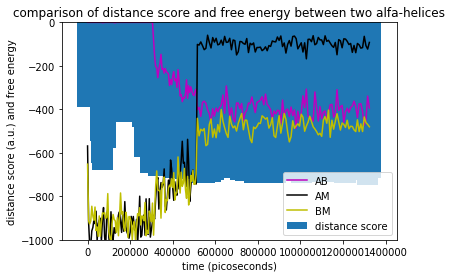

In [21]:
file = "DATA/AATYK2_LMTK2/daft-00001/coords.dat"
energy = get_energy(file)
write_file(file)
coordinates = get_coords(file, get_seq_list(sequence))
interesting_df, lowest_energy = find_interesting(energy, coordinates)
# introductory data analyses
distence_df = get_distance_score(coordinates, sequence)
# comparison of the data
comparison_plot(distence_df, energy)

Figuur 1: energyverloop vergeleken met de score die de helices hebben gekregen naar aanlijding van hun dichtbijheid van elkaar voor run 1 van het eiwit AATYK2_LMTK2.
In dit figuur staan de blauwe balken voor de dichtbijheidsscore. Hoe negatiever, hoe dichterbij ze zijn. De lijnen representered de vrije energie in verschillende situaties: Paars representeert de vrije energie tussen de twee helices, geel de vrije energie tussen helix 2 en het membraan en zwart de vrije energie tussen helix 1 en het membraan.

## Orientatie analyse

### Range visualisatie

Om een idee te krijgen van de georiënteerde data, wordt de range
bepaald waarin de residuen 4 tot en met 9 liggen van helix 2, voor de interessante samples en voor
de overige samples, dit is de range voor run 1 van het eiwit AATYK2_LMTK2.

In [22]:
means_df, inter, ninter = orientation_fabrication(coordinates, 
                                                  interesting_df, 
                                                  len(sequence))
visualize_range(inter, ninter)

Axis | strong interactions | weaker interactions
 X   | -6.77 till 8.35 | -45.63 till 45.28 
 Y   | 0 till 15.75 | -44.96 till 40.89 
 Z   | -8.31 till 6.36 | -25.83 till 21.72


Table 1: De range waarin de X, Y en Z coordinaten van residues 4 tot 8 van helix 2, ten opzichte van residues 4 tot 8 van helix 1 van run 1, eiwit AATYK2_LMTK2.

### Scatterplot

de georiënteerde data is met behulp van matplotlib en Axes3d gevisualiseerd met behulp van
een scatterplot, waarbij de interessante tijdspunten anders zijn gekleurd, om een idee te krijgen van waar de data zich bevindt. Figuur 2 laat dit zien voor run 1 van het eiwit AATYK2_LMTK2.

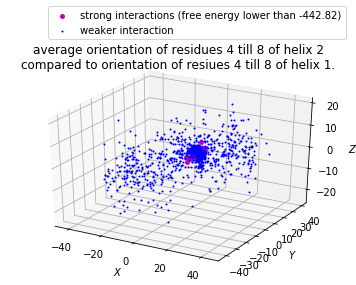

In [23]:
scatterplot_orientation(means_df, lowest_energy, interesting_df)

Figuur 2: gemiddelde orientatie van residues 4 tot 8 van helix 2, ten opzichte van residues 3 tot 8 van helix 1 van het eiwit AATYK2_LMTK2, run 1.
De z-as is zo opgesteld dat hij door residuen 4 tot 9 van helix 1 heen
loopt, waarbij 0 de onderkant van residu 9 is en hoe hoger het getal, hoe verder naar de top van de helix je gaat. De y-as loopt van voor de helix naar de achterkant van de helix en de x-as van links naar rechts.

### kernel density estimate

Om te kijken waar de meeste data zich bevond, werd een kde gemaakt en geplot met behulp van matplotlib. Figuur 3 laat het resultaat zien voor run 1 van het eiwit AATYK2_LMTK2.

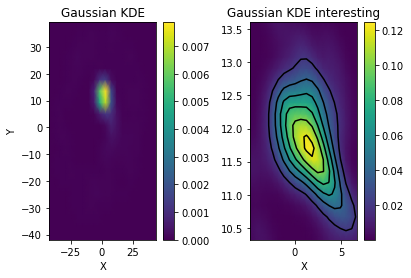

In [24]:
hist, histi = gaussian_kde(means_df, interesting_df.index, -0, contour=False)

Figuur 3: gaussian kernel density estimate voor de interessante en overige reads van run 1, eiwit AATYK2_LMTK2. 
Hoe hoger op de kleurenbalk, hoe meer data zich daar waarschijnlijk bevind.

### Plaatsingsanalyze gehele eiwit

Om een beeld te krijgen van de plaatsing van de data in het eiwit, zijn twee piecharts gemaakt, die de percentages per plaats laten zien. 1 is voor de interessante data en de andere voor de bulk data.

In [ ]:
bla = analyse_series("AATYK2_LMTK2")

Figuur 4: Piecharts van de plaatsing van de data van het eiwit AATYK2_LMTK2.
De plaats 121 (linksachterbeneden) is het grootste bij de interesting reads en 111 (linksvoorbenden) bij de andere reads.

## Orientatie interactie analyse

In [ ]:
%%capture
orientation_interaction_df = get_orientation_interaction()

### Groepen interactiesterktes

In de tabel hieronder is te zien welke eiwitten in welke groep zitten die wordt gebruikt in de volgende plot.

In [ ]:
strengths, inter_vals, bulk_vals, groups = analyze_orientation_interaction(
    orientation_interaction_df)
strengths_df = pd.DataFrame.from_dict(strengths, "index")

strengths_df.T

### Barplot plaatsing

Er is eerst een barplot gemaakt om per groep te kijken waar de data zich gemiddeld in die groep bevindt.

In [ ]:
make_placings_barplot(orientation_interaction_df, groups, strengths)

Figuur 5: barplot die per groep laat zien hoe de data verdeeld is. 
In de groep "low" zitten alle eiwitten met een interactie sterkte die lager is dan 0.15, in de groep "average" zitten alle eiwitten met een interactiesterkte tussen de 0.15 en 0.75 en in de groep "high" zitten de eiwitten die een interactiesterkte hebben die groter is dan 0.75.

### Variantie analyse

Hieronder zijn de plaatscombinaties te zien, waarbij de groepen significant van elkaar verschillen. Dit is berekend met behulp van ANOVA en om significant gevonden te worden, moet er een p-value van lager dan 0.05 gevonden worden in de test.

In [ ]:
none = True
# for every combination with a specific number of places, calculate anova
for L in range(1, 9):
    for subset in itertools.combinations(orientation_interaction_df.columns[:-2], L):
        pval = do_one_way_ANOVA_places(list(subset), inter_vals, bulk_vals).pvalue
        if pval <= 0.05:
            none = False
            print("interesting", subset, pval)
        
        pval = do_one_way_ANOVA_places(list(subset), 
                                       inter_vals, 
                                       bulk_vals, False).pvalue
        if pval <= 0.05:
            none = False
            print("non-interesting", subset, pval)

if none:
    print("No significant combinations")

\clearpage

# Discussie

Het doel van dit onderzoek was om erachter te komen hoe de alphahelices van RTKs die in de membranen zitten waar deze RTK eiwitten in zitten, met elkaar samenwerken en hoe de plaatsing van deze dimeren ten opzichte van elkaar en het membraan, te maken heeft met de sterkte van de interactie tussen de alphahelices. Er is in dit onderzoek gefocussed op de residuen 4 tot en met 8 van beide helices, omdat de plaatsing hiervan bepaald hoe de residuen 1 tot 3 zich plaatsen ten opzichte van elkaar en dit de residuen zijn die het eiwit binden en vermoedelijk voor de activiteit zorgen. Verder is er bij de analyse van de plaatsen gekozen om alleen de groffe plaatsing te analyseren en niet de specifieke plaatsing, omdat het verschil tussen die twee te klein werd geacht om extra code te schrijven voor specifieke analyse. Omdat er in de wetenschap nog geen onderzoek is gedaan naar de interactie, interactiesterkte en relative oriëntatie van de helices, zijn de resultaten niet te vergelijken met de wetenschap. Omdat er bij de plaatsingsanalyse en de ANOVAs geen significante verschillen zijn gevonden, kan er nog niks gezegd worden over de relatieve oriëntatie en de interactiesterkte en daarmee zijn de doelen van dit onderzoek niet behaald. Wat er veranderd kan worden is het focussen op de residuen 4 tot en met 8 in plaats van de gehele alphahelices. Ook zou de specifieke plaatsing beter geanalyseerd kunnen worden en zouden alle 58 eiwitten meegenomen kunnen worden in plaats van alleen degenen met meer dan 400 DAFT-runs. Voor een vervolgonderzoek zou kunnen worden gezocht naar een regressie door de tijd in plaats van een gemiddelde van alles en er zouden strengere normen kunnen worden gesteld op wanneer een meting interessant is.

# Referenties

###### [1]: https://pandas.pydata.org
###### [2]: http://www.numpy.org
###### [3]: https://matplotlib.org
###### [4]: https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/api.html#module-mpl_toolkits.mplot3d.axes3d
###### [5]: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.gaussian_kde.html